In [1]:
import soundfile as sf
from scipy.interpolate import interp1d
import numpy as np
import sys
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def length(x):
    return np.max(np.asarray(x).shape)

In [3]:
def Stft(xt,wlen):
############ Taking Stft of the signal#################
    nchan,nsamp = xt.shape
    win = np.sin(np.arange(0.5,wlen+0.5)/wlen*np.pi).reshape(1024,1) #Applying sine window for short time fft
    nfram = nsamp//wlen*2 - 1
    nbin = wlen//2 + 1
    
    startSample = (np.arange(0,nfram)*wlen/2 + 1).T
    endSample = (np.arange(0,nfram)*wlen/2+wlen).T
    
    X = np.zeros(shape=(nchan,nbin,nfram)) + 1j*np.zeros(shape=(nchan,nbin,nfram))
    
    for i in range(nchan):
        for t in range(nfram):
            frame = (xt[i,[np.arange(t*wlen//2,t*wlen//2+wlen)]].T)*win ## Multiplying frame of every channel with sine window
            fframe = np.fft.fft(frame.T).reshape(wlen,1)
            X[[i],:,t] = fframe[np.arange(nbin)].T
            
    return X,startSample,endSample


In [4]:
############################ Preprocessing signal part #############################
def Preprocess(micPosT,c,azimuthGrid,elevationGrid,alphaRes):
    
    nDirection = length(azimuthGrid)
    nMic = micPosT.shape[0]
    pairId = nchoosek(np.arange(nMic),2)
    nMicPair = pairId.shape[0]
    
    ##Microphone direction vector (in xyz) for each pair
    pfMn1n2 = micPosT[pairId[:,0],:] - micPosT[pairId[:,1],:]
    
    dMic = np.sqrt(np.sum(np.power(pfMn1n2,2),1)).reshape(nMicPair,1)
    Pjk = np.zeros((3,nDirection))
    
    
    
    Pjk[0,:], Pjk[1,:], Pjk[2,:] = sph2cart(np.deg2rad(azimuthGrid),np.deg2rad(elevationGrid),1)
    
    Pjk_All = np.tile(Pjk,(nMicPair,1,1))
    Pjk_All = np.transpose(Pjk_All,(2,1,0))
    
    Mn1n2_All = np.tile(pfMn1n2.T,(nDirection,1,1))
    
    temp_int = np.squeeze(shiftdim(np.sum(Pjk_All*Mn1n2_All,axis=1,keepdims=True),1))/np.tile(dMic,(1,nDirection))
    temp_int = np.clip(temp_int,-1,1)
    alpha = np.real(np.rad2deg(np.arccos(temp_int)))  
    
    alphaSampled = np.ndarray(nMicPair,dtype = np.object)
    tauGrid = np.ndarray(nMicPair,dtype = np.object)
    
    for index in range(nMicPair):
        alphaSampled[index] = np.arange(np.floor(np.amin(alpha[[index],:])/alphaRes) * alphaRes , np.ceil(np.amax(alpha[[index],:])/alphaRes) * alphaRes+1,alphaRes)
        tauGrid[index] = dMic[index]*np.array([np.cos(np.deg2rad(alphaSampled[index]))/c])
     
        
    return alphaSampled,tauGrid,pairId,alpha
    

In [5]:
############Spherical coordinate to cartesian Coordinate
def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z

In [6]:
#############List possible combinations of microphones possible
def nchoosek(arr,element):
    from itertools import combinations
    comb = list(combinations(arr, element))  
    comb = np.asarray(comb)
    return comb

In [7]:
################Shift the dimension of the given matrix
def shiftdim(A,num):
    a,b,c = A.shape
    if num ==1 :
        temp = np.transpose(A,(1,2,0))
    else:
        raise Exception("Error number")
    return temp

In [8]:
def PHAT_implement(X,f,tauGrid):
    
    if X.ndim == 2:
        X = X.reshape(2,512,1)
    
    X1 = X[0,:,:]
    X2 = X[1,:,:]
    nbin,nFrames = X1.shape
    ngrid = length(tauGrid)
    P = X1*np.conj(X2)
    P = P/np.abs(P)
    spec = np.zeros((ngrid,nbin,nFrames))
    for pkInd in range(ngrid):
        EXP = np.tile(np.exp(-2*1j*np.pi*tauGrid[pkInd]*f),(1,nFrames))
        spec[pkInd,:,:] = np.real(P)*np.real(EXP) - np.imag(P)*np.imag(EXP)
    
    return spec
    

In [9]:
def interp1q(x,y,xin):
    final_out = np.zeros((xin.shape[0],y.shape[1]))
    for i in range(y.shape[1]):
        inter_dat = interp1d(x, (y.T)[i])
        interpolate_dat = inter_dat(xin) 
        final_out[:,i] = interpolate_dat 
    return final_out

In [10]:
def Compute_GCCPHAT_GRID(X_current,alphaSampled,tauGrid,pairId,alpha,nGrid,nframe,f,freqBins):
    
    nPairs = alphaSampled.shape[0]
    
    specInst = np.zeros((nGrid, nframe))
    
    for i in range(nPairs):
        spec = PHAT_implement(np.squeeze(np.squeeze(X_current[pairId[[i],:],:])[:,freqBins]),np.squeeze(f[freqBins],axis=0),tauGrid[i].T)
        specSampledgrid = np.sum(spec,axis=1)
        specCurrentPair = interp1q(alphaSampled[i], specSampledgrid, alpha[i,:])
        specInst = specInst + specCurrentPair
        
    return specInst

In [11]:
#################### Searching the peaks::::::::::::::::::::
def Search_peaks(specGlobal,nEl,nAz,nsrc,azimuthGrid,elevationGrid,MinAngle):
    
    ppfSpec2D = (specGlobal.reshape(nEl,nAz))

    ppfPadpeakFilter = np.ones((ppfSpec2D.shape[0]+2,ppfSpec2D.shape[1]+2)) * -np.inf
    
    ppfPadpeakFilter[1:-1,1:-1] = ppfSpec2D
    
    ppiPeaks = ((ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[0:-2,1:-1])& 
    (ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[2:,  1:-1])& 
    (ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[1:-1,0:-2])& 
    (ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[1:-1,2:  ])& 
    (ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[0:-2,0:-2])& 
    (ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[0:-2,2:  ])& 
    (ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[2:,  0:-2])& 
    (ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[2:,  2:  ])).astype(int)
    
    iNbLocalmaxima = np.sum(ppiPeaks)
    
    ppfSpec2D_peaks = (ppfSpec2D - np.min(ppfSpec2D)) * ppiPeaks
    
    pfSpec1D_peaks= (ppfSpec2D_peaks).reshape(1,nEl*nAz)
    
    piIndexPeaks1D = np.argsort(-pfSpec1D_peaks)
    piEstSourcesIndex = piIndexPeaks1D[:,0]
    
    index = 1 
    iNbSourcesFound = 1
    
    
    ### Calculating the Curvilinear distance between sources #############################
    while (iNbSourcesFound < nsrc and index <= iNbLocalmaxima):
        bAngleAllowed = 1
    
        for i in range(length(piEstSourcesIndex)):
            val=np.sin(np.deg2rad(elevationGrid[0,piEstSourcesIndex[i]]))*np.sin(np.deg2rad(elevationGrid[0,piIndexPeaks1D[0,index]]))+np.cos(np.deg2rad(elevationGrid[0,piEstSourcesIndex[i]]))*np.cos(np.deg2rad(elevationGrid[0,piIndexPeaks1D[0,index]]))*np.cos(np.deg2rad(azimuthGrid[0,piIndexPeaks1D[0,index]])-np.deg2rad(azimuthGrid[0,piEstSourcesIndex[i]])) 
            dist = np.rad2deg(np.arccos(val))
            if(dist < MinAngle):
                bAngleAllowed =0
                break
    
        if(bAngleAllowed):
            piEstSourcesIndex = np.append(piEstSourcesIndex,piIndexPeaks1D[0,index])
            iNbSourcesFound = iNbSourcesFound + 1
    
        index = index + 1
        
    azEst = azimuthGrid[0,piEstSourcesIndex]
    elEst = elevationGrid[0,piEstSourcesIndex]
        
    return azEst,elEst
    

In [12]:
def Compute_Grid(alphaSampled,tauGrid,pairId,alpha,nEl,nAz,gridRes,MinAngle):
       
    #x,fs = sf.read('8D.wav')
    x,fs = sf.read('test.wav')
    #x,fs = sf.read('male_female_mixture.wav')
    
    nsamp,nchan = x.shape
    #print(x.shape)    

    
    X,startSample,endSample= Stft(x.T,wlen)
    X = X[:,1:,:]  
    #print(X.shape)
        
    nframe = X.shape[2]
    frameStart = 0
    frameEnd = nframe-1
    nblocks = 0
    blockTimestamps = ((startSample[frameEnd] + startSample[frameStart])/2)/fs
    X_current = X[:,:,np.arange(frameStart,frameEnd+1)]
    #print(X_current.shape)
    

    specInst = Compute_GCCPHAT_GRID(X_current,alphaSampled,tauGrid,pairId,alpha,nAz*nEl,nframe,f,freqBins)
    
    ######Applying max pooling function
    
    specGlobal = np.array([np.max(specInst,1)]).T
    
    azEst,elEst = Search_peaks(specGlobal,nEl,nAz,nsrc,azimuthGrid,elevationGrid,MinAngle)
    
    for i in range(nsrc):
        print("Source %d :" %(i+1))
        print("   ")
        print("Azimuth = {}" .format(azEst[i]))
        print("Elevation = {}" .format(elEst[i]))
        print("   ")
    
    return specGlobal
    

Source 1 :
   
Azimuth = 13
Elevation = -52
   


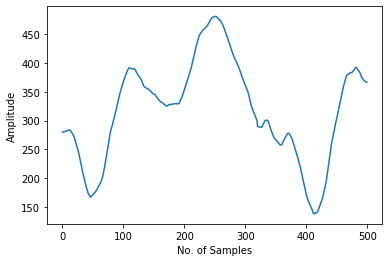

In [13]:
if __name__ == "__main__":
    
    nsrc = 1
    c = 343
    wlen = 1024
    
    gridRes = 1 #1 degree resolution on 3D
    alphaRes = 5 # interpolation resolution
    MinAngle = 10 #Minimum Angles between the peaks
    
    fs = 16000
    
    f = ((fs/wlen)*np.array([np.arange(1,wlen//2+1)])).T
    freqBins = np.array([np.arange(length(f))])
    
    micPos = [[ 0.055,  -0.053,  -0.085, -0.085, -0.054,  0.051,  0.085, 0.085],
              [ 0.085,   0.085,   0.052, -0.055, -0.085, -0.085, -0.054, 0.054],
              [-0.055,   0.053,  -0.054,  0.052, -0.054,  0.054, -0.055, 0.052]]
    
    micPos = np.asarray(micPos)
    
    azimuth = np.asarray([np.arange(-179,181,gridRes)]).T
    elevation = np.asarray([np.arange(-90,91,gridRes)])
    
    nAz = length(azimuth)
    nEl = length(elevation)
    
    azimuthGrid = np.tile(azimuth,(nEl,1)).T
    elevationGrid = (np.tile(elevation,(nAz,1)).T).reshape(1,nAz*nEl)
    
    alphaSampled,tauGrid,pairId,alpha = Preprocess(micPos.T,c,azimuthGrid,elevationGrid,alphaRes)
    
    peaks = Compute_Grid(alphaSampled,tauGrid,pairId,alpha,nEl,nAz,gridRes,MinAngle)
    
    
    fig, ax = plt.subplots()
    ax.plot((peaks.reshape(65160))[4000:4500])

    ax.set(xlabel='No. of Samples', ylabel='Amplitude')

    fig.savefig("Peaks.png")
    plt.show()
    